<a href="https://colab.research.google.com/github/mJekal/PyTorch_study/blob/main/classficiation_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [4]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform)

In [5]:
print(train_DS)
print(test_DS)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
BATCH_SIZE = 32
train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE,shuffle=True)

In [7]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(28*28, 100),
                                    nn.ReLU(),
                                    nn.Linear(100,10))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        # x_batch, _ = next(iter(train_DL))
        # print(x_batch.shape)
        # flat = torch.flatten(x_batch, start_dim=1)
        # print(flat.shape)
        x = self.linear(x)
        return x

In [8]:
model = MLP()
print(model)
x_batch, _ = next(iter(train_DL))

MLP(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [9]:
from torch import optim

LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()

def Train(model, train_DL, criterion, optimizer):

    loss_history =[]
    Len = len(train_DL.dataset)

    model.train()
    for ep in range(EPOCH):
        running_loss = 0
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            q = model(x_batch)

            loss = criterion(q, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_batch = loss.item() * x_batch.shape[0]
            running_loss += loss_batch

        loss_e = running_loss/Len
        loss_history += [loss_e]
        print(f"Epoch: {ep+1}: train loss: {round(loss_e,3)}")

    return loss_history

Epoch: 1: train loss: 0.316
Epoch: 2: train loss: 0.146
Epoch: 3: train loss: 0.101
Epoch: 4: train loss: 0.076
Epoch: 5: train loss: 0.059


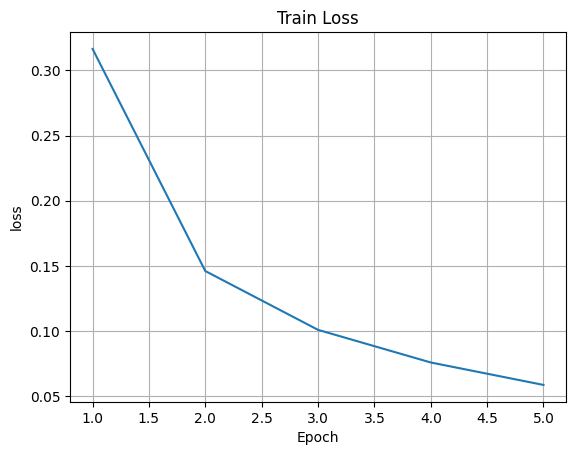

In [10]:
model = MLP().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_history = Train(model, train_DL, criterion, optimizer)

plt.plot(range(1,EPOCH+1),loss_history)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title("Train Loss")
plt.grid()

In [11]:
save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/MLP_MNIST.pt'
torch.save(model.state_dict(), save_model_path)

In [12]:
load_model = MLP().to(DEVICE)
load_model.load_state_dict(torch.load(save_model_path, map_location=DEVICE))

<All keys matched successfully>

In [13]:
def Test(model, test_DL):
    model.eval()
    with torch.no_grad():
        running_correct = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            q = model(x_batch)

            pred = q.argmax(dim=1)
            corrects_batch = torch.sum(pred == y_batch).item()
            running_correct += corrects_batch
        accuracy_e = running_correct/len(test_DL.dataset)*100
    print(f"Test accuracy: {running_correct}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")

In [14]:
Test(load_model, test_DL)

Test accuracy: 9760/10000 (97.6 %)


In [15]:
def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        q = model(x_batch)
        pred = q.argmax(dim=1)

    x_batch = x_batch.to("cpu")

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")

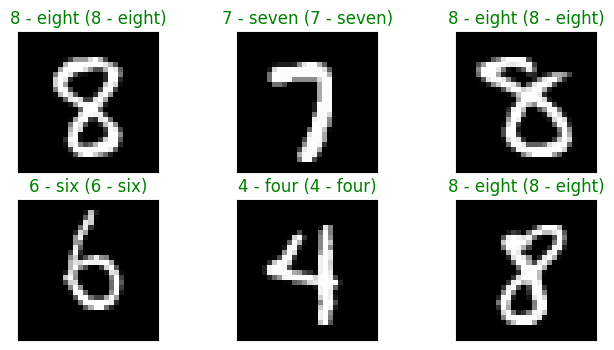

In [16]:
Test_plot(load_model, test_DL)